In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [9]:
!pip install mediapipe

In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing)
import os
import IPython #display picture
import cv2
import mediapipe as mp
import matplotlib.pyplot as plt
from PIL import Image #load picture
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [11]:
seed = 333
image_path = []
label = []

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if not filename.endswith('.json'):
            image_path.append(os.path.join(dirname, filename))
            label.append(os.path.split(dirname)[1])

In [12]:
image_path = pd.Series(image_path, name='path')
label = pd.Series(label, name='label')
df = pd.concat([image_path,label], axis=1)

In [13]:
labels=[]
X=[]

for i in range(len(df)):
    img = Image.open(df['path'][i])
    img = img.resize((128, 128))
    img = np.array(img)
    if len(img.shape)>2 and img.shape[2] == 4:
        img = img[:, :, :3]
    elif len(img.shape)<3:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    if img.shape[2] == 3:
        X.append(img)
        labels.append(df['label'][i])

In [14]:
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(labels)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1730552546.626392     122 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1730552546.691392     122 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1730552546.737622     123 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


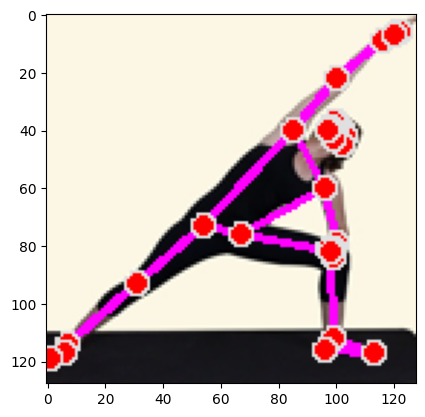

In [15]:
mp_pose = mp.solutions.pose
mp_draw = mp.solutions.drawing_utils
pose = mp_pose.Pose()

img = X[333]
results = pose.process(img)
mp_draw.draw_landmarks(img, results.pose_landmarks,
                        mp_pose.POSE_CONNECTIONS,
                        mp_draw.DrawingSpec((255, 0, 0), 2, 2),
                        mp_draw.DrawingSpec((255, 0, 255), 2, 2)
                       )
plt.imshow(img)

In [16]:
x_position = np.zeros((len(X),33,4))
y_position = np.zeros(label_encoded.shape)
x_position.shape, y_position.shape

((2756, 33, 4), (2756,))

In [17]:
for i in range(len(X)):
    results = pose.process(X[i])
    if results.pose_landmarks is not None:
        positions = results.pose_landmarks.landmark
        j=0
        for landmark in positions:
            x = landmark.x
            y = landmark.y
            z = landmark.z
            v = landmark.visibility
            x_position[i,j] = [x,y,z,v]
            y_position[i] = label_encoded[i]+1
            j+=1

In [18]:
non_zero_mask = np.any(x_position != 0, axis=(1,2))
x_position = x_position[non_zero_mask]
y_position = y_position[y_position != 0]

y_position.shape, x_position.shape

((2528,), (2528, 33, 4))

In [19]:
x_position = x_position.reshape(x_position.shape[0],x_position.shape[1]*x_position.shape[2])

In [20]:
X_train, X_test, y_train, y_test = train_test_split(x_position, y_position, 
                                                    test_size=0.2, shuffle=True,
                                                    random_state=seed)

In [21]:
smote = SMOTE(random_state=seed, k_neighbors=3)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [22]:
forest = RandomForestClassifier(n_estimators=200,random_state=seed)

forest.fit(X_resampled, y_resampled)

y_pred = forest.predict(X_test)
accuracy_score(y_test, y_pred)

0.9644268774703557

In [23]:
from joblib import dump, load

# Save the model to a file
dump(forest, 'random_forest_model.joblib')


['random_forest_model.joblib']

In [ ]:
# Load the model from the file
forest = load('random_forest_model.joblib')
